In [1]:
# #Load the dataset
# import zipfile
# zip = zipfile.ZipFile('food-11.zip')
# zip.extractall()

In [2]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
torch.cuda.empty_cache()

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

In [3]:
# It is important to do data augmentation in training.

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3)),
#     transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
# A greater batch size usually gives a more stable gradient.
batch_size = 64

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set1 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
train_set2 = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
train_set = ConcatDataset([train_set1, train_set2])
valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(256, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.65),
            #nn.Dropout(0.4),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, 11)
        )

    def forward(self, x):

        x = self.cnn_layers(x)

        x = x.flatten(1)

        x = self.fc_layers(x)
        return x

In [6]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]
    
def get_pseudo_labels(dataset, model, threshold=0.8):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    for i, batch in enumerate(data_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))

    model.train()
    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset

In [7]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# # Initialize a model, and put it on the device specified.
# model = Classifier().to(device)
# model.device = device

# Resnet load
model = torchvision.models.resnet18(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11).to(device)
model.device = device
for param in model.parameters():
    param.requires_grad = True

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)
# optimizer = torch.optim.AdamW(model.parameters())

# The number of training epochs.
n_epochs = 40

# Whether to do semi-supervised learning.
do_semi = True

# record information
best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []
model_path = "model.ckpt"

for epoch in range(n_epochs):    
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi and best_acc > 0.8:
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set = get_pseudo_labels(unlabeled_set, model)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)


    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    # ------Record every time information------
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)

  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 001/040 ] loss = 1.55075, acc = 0.51031


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 001/040 ] loss = 0.87742, acc = 0.73636
saving model with acc 0.736


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 002/040 ] loss = 0.75622, acc = 0.77223


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 002/040 ] loss = 0.74730, acc = 0.76676
saving model with acc 0.767


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 003/040 ] loss = 0.58214, acc = 0.82957


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 003/040 ] loss = 0.70499, acc = 0.76733
saving model with acc 0.767


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 004/040 ] loss = 0.48837, acc = 0.85696


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 004/040 ] loss = 0.66655, acc = 0.79290
saving model with acc 0.793


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 005/040 ] loss = 0.43095, acc = 0.86985


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 005/040 ] loss = 0.64185, acc = 0.79176


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 006/040 ] loss = 0.39285, acc = 0.88338


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 006/040 ] loss = 0.68758, acc = 0.78210


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 007/040 ] loss = 0.36215, acc = 0.89014


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 007/040 ] loss = 0.65587, acc = 0.80142
saving model with acc 0.801

New data:  3350



  0%|          | 0/148 [00:00<?, ?it/s]

[ Train | 008/040 ] loss = 0.41560, acc = 0.87532


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 008/040 ] loss = 0.66422, acc = 0.79517

New data:  3696



  0%|          | 0/154 [00:00<?, ?it/s]

[ Train | 009/040 ] loss = 0.41118, acc = 0.87723


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 009/040 ] loss = 0.65961, acc = 0.80994
saving model with acc 0.810

New data:  3827



  0%|          | 0/156 [00:00<?, ?it/s]

[ Train | 010/040 ] loss = 0.41975, acc = 0.87390


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 010/040 ] loss = 0.71271, acc = 0.78381

New data:  3875



  0%|          | 0/156 [00:00<?, ?it/s]

[ Train | 011/040 ] loss = 0.39104, acc = 0.88101


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 011/040 ] loss = 0.62377, acc = 0.81790
saving model with acc 0.818

New data:  4000



  0%|          | 0/158 [00:00<?, ?it/s]

[ Train | 012/040 ] loss = 0.38461, acc = 0.88499


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 012/040 ] loss = 0.61262, acc = 0.81619

New data:  4036



  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 013/040 ] loss = 0.36324, acc = 0.88964


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 013/040 ] loss = 0.62632, acc = 0.79545

New data:  4050



  0%|          | 0/159 [00:00<?, ?it/s]

[ Train | 014/040 ] loss = 0.35107, acc = 0.89603


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 014/040 ] loss = 0.61496, acc = 0.81449

New data:  4185



  0%|          | 0/161 [00:00<?, ?it/s]

[ Train | 015/040 ] loss = 0.33692, acc = 0.89829


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 015/040 ] loss = 0.71287, acc = 0.77756

New data:  4233



  0%|          | 0/162 [00:00<?, ?it/s]

[ Train | 016/040 ] loss = 0.33399, acc = 0.89699


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 016/040 ] loss = 0.59096, acc = 0.81307

New data:  4380



  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 017/040 ] loss = 0.33926, acc = 0.89625


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 017/040 ] loss = 0.60720, acc = 0.81591

New data:  4377



  0%|          | 0/164 [00:00<?, ?it/s]

[ Train | 018/040 ] loss = 0.33438, acc = 0.89701


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 018/040 ] loss = 0.60959, acc = 0.82699
saving model with acc 0.827

New data:  4423



  0%|          | 0/165 [00:00<?, ?it/s]

[ Train | 019/040 ] loss = 0.32879, acc = 0.90265


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 019/040 ] loss = 0.58125, acc = 0.83580
saving model with acc 0.836

New data:  4557



  0%|          | 0/167 [00:00<?, ?it/s]

[ Train | 020/040 ] loss = 0.34538, acc = 0.89848


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 020/040 ] loss = 0.55117, acc = 0.84886
saving model with acc 0.849

New data:  4474



  0%|          | 0/166 [00:00<?, ?it/s]

[ Train | 021/040 ] loss = 0.31869, acc = 0.90277


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 021/040 ] loss = 0.63433, acc = 0.82386

New data:  4557



  0%|          | 0/167 [00:00<?, ?it/s]

[ Train | 022/040 ] loss = 0.32268, acc = 0.90438


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 022/040 ] loss = 0.62136, acc = 0.81563

New data:  4453



  0%|          | 0/165 [00:00<?, ?it/s]

[ Train | 023/040 ] loss = 0.29448, acc = 0.90919


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 023/040 ] loss = 0.58215, acc = 0.83665

New data:  4607



  0%|          | 0/168 [00:00<?, ?it/s]

[ Train | 024/040 ] loss = 0.31332, acc = 0.90578


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 024/040 ] loss = 0.59066, acc = 0.83580

New data:  4558



  0%|          | 0/167 [00:00<?, ?it/s]

[ Train | 025/040 ] loss = 0.30382, acc = 0.90840


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 025/040 ] loss = 0.61838, acc = 0.82386

New data:  4687



  0%|          | 0/169 [00:00<?, ?it/s]

[ Train | 026/040 ] loss = 0.30849, acc = 0.90560


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 026/040 ] loss = 0.55934, acc = 0.84062

New data:  4576



  0%|          | 0/167 [00:00<?, ?it/s]

[ Train | 027/040 ] loss = 0.29408, acc = 0.91243


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 027/040 ] loss = 0.59462, acc = 0.81903

New data:  4656



  0%|          | 0/169 [00:00<?, ?it/s]

[ Train | 028/040 ] loss = 0.28507, acc = 0.91392


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 028/040 ] loss = 0.59067, acc = 0.84034

New data:  4718



  0%|          | 0/169 [00:00<?, ?it/s]

[ Train | 029/040 ] loss = 0.28307, acc = 0.91522


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 029/040 ] loss = 0.60651, acc = 0.82415

New data:  4735



  0%|          | 0/170 [00:00<?, ?it/s]

[ Train | 030/040 ] loss = 0.27915, acc = 0.91452


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 030/040 ] loss = 0.58374, acc = 0.82699

New data:  4718



  0%|          | 0/169 [00:00<?, ?it/s]

[ Train | 031/040 ] loss = 0.27978, acc = 0.91540


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 031/040 ] loss = 0.62969, acc = 0.82472

New data:  4852



  0%|          | 0/172 [00:00<?, ?it/s]

[ Train | 032/040 ] loss = 0.28834, acc = 0.91243


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 032/040 ] loss = 0.57974, acc = 0.84460

New data:  4730



  0%|          | 0/170 [00:00<?, ?it/s]

[ Train | 033/040 ] loss = 0.28689, acc = 0.91480


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 033/040 ] loss = 0.55091, acc = 0.83182

New data:  4766



  0%|          | 0/170 [00:00<?, ?it/s]

[ Train | 034/040 ] loss = 0.27652, acc = 0.91673


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 034/040 ] loss = 0.63508, acc = 0.82784

New data:  4808



  0%|          | 0/171 [00:00<?, ?it/s]

[ Train | 035/040 ] loss = 0.27188, acc = 0.91767


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 035/040 ] loss = 0.59042, acc = 0.83409

New data:  4918



  0%|          | 0/173 [00:00<?, ?it/s]

[ Train | 036/040 ] loss = 0.27344, acc = 0.91862


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 036/040 ] loss = 0.57040, acc = 0.84574

New data:  4849



  0%|          | 0/172 [00:00<?, ?it/s]

[ Train | 037/040 ] loss = 0.27937, acc = 0.91543


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 037/040 ] loss = 0.57507, acc = 0.82955

New data:  4826



  0%|          | 0/171 [00:00<?, ?it/s]

[ Train | 038/040 ] loss = 0.25944, acc = 0.92443


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 038/040 ] loss = 0.56942, acc = 0.85028
saving model with acc 0.850

New data:  4883



  0%|          | 0/172 [00:00<?, ?it/s]

[ Train | 039/040 ] loss = 0.26029, acc = 0.92115


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 039/040 ] loss = 0.60291, acc = 0.83835

New data:  4980



  0%|          | 0/174 [00:00<?, ?it/s]

[ Train | 040/040 ] loss = 0.27631, acc = 0.91586


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 040/040 ] loss = 0.52531, acc = 0.85028


In [8]:
model.eval()

predictions = []

for batch in test_loader:
    imgs, labels = batch

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    
    
    
with open("predict.csv", "w") as f:
    f.write("Id,Category\n")

    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

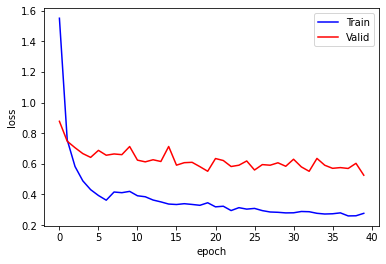

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_record))
fig, ax = plt.subplots()
ax.plot(x, train_loss_record, color="blue", label="Train")
ax.plot(x, valid_loss_record, color="red", label="Valid")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc="upper right") 

plt.show()

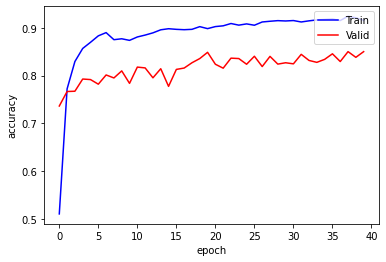

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_record))
fig, bx = plt.subplots()
train_acc_record = torch.tensor(train_acc_record, device = 'cpu')
valid_acc_record = torch.tensor(valid_acc_record, device = 'cpu')
bx.plot(x, train_acc_record, color="blue", label="Train")
bx.plot(x, valid_acc_record, color="red" , label="Valid")
bx.set_xlabel('epoch')
bx.set_ylabel('accuracy')
bx.legend(loc="upper right")

plt.show()